# DSE 200 FINAL PROJECT
## Fall 2025
### Due Date: November 21th, 2025

This project is culmination of all you’ve learned in this course! You should expect to spend <b>24-32 total hours</b> on the project. Be sure to read all of the items below before starting.

There are a number of steps outlined below, but is critical that you do not view this as an entirely linear process.  Remember that the science component in data science is the creation of a hypothesis based on exploration and testing of that hypothesis through analysis.  You may need to go through many of these steps multiple times before you arrive at meaningful hypothesis or conclusions.

## Step 1: Find a dataset or datasets

Based on your interest, identify a dataset which you will want to examine.  You will find a starting point for where you can find open datasets at the end of this notebook, but feel free to use other datasets you have access to and can publicly share results about.


This step may take some time, as you’ll likely look at a number of datasets before you find one (or more) which holds promising data for the kinds of questions you want to ask. You are expected to use at least two interconnected datasets, e.g., two tables in one database or a combination of datasets which you can merge in some meaningful way.


In [558]:
import kagglehub
import os
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, r2_score, mean_squared_error, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

Donwload what we need from kaggle

In [2]:

# Download latest version
path = kagglehub.dataset_download("mattiuzc/stock-exchange-data")

path2 = kagglehub.dataset_download("saketk511/world-important-events-ancient-to-modern")

print("Path to dataset files:", path)

#with open(path)

Path to dataset files: C:\Users\jlu2\.cache\kagglehub\datasets\mattiuzc\stock-exchange-data\versions\2


Load the Data info dataframes

In [3]:
df_data = pd.read_csv(os.path.join(path, "indexData.csv"))
df_info = pd.read_csv(os.path.join(path, "indexInfo.csv"))
df_processed = pd.read_csv(os.path.join(path, "indexProcessed.csv"))
# df_events = pd.read_csv(os.path.join(path2, "World Important Dates.csv"))

df_events = pd.read_csv(
    os.path.join(path2, "World Important Dates.csv"),
    engine="python",
    quotechar='"',
    skipinitialspace=True
)
# df_events = pd.read_csv(
#     os.path.join(path2, "World Important Dates.csv"),
#     engine="python",
#     quotechar='"',
#     skipinitialspace=True,
#     on_bad_lines="skip"    # or "warn"
# )


In [7]:
#PERFORM AND EXPLAIN YOUR EXPLORATORY ANALYSIS IN THIS SECTION

### Explaination of data analysis
- Looking for data shape, content, & quality issues

#### Data overview
indexData.csv: daily price + volume data for major global indices

indexInfo.csv: metadata: region, exchange, currency, index name == we will skip this dataset sine it does not contain information useful to us

indexProcessed.csv: cleaned version of the price data with USD-normalized closes (CloseUSD)

From the review we can see that while df_data has the only missing values which also are only numeric columns, the df_processed has been cleaned of all the missing data issues.
Next we'll check the size of the dataframe before the merge and then after to make sure we don't have any loss.

In [14]:
df_processed.info()
print('total na:',df_processed.isna().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104224 entries, 0 to 104223
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Index      104224 non-null  object 
 1   Date       104224 non-null  object 
 2   Open       104224 non-null  float64
 3   High       104224 non-null  float64
 4   Low        104224 non-null  float64
 5   Close      104224 non-null  float64
 6   Adj Close  104224 non-null  float64
 7   Volume     104224 non-null  float64
 8   CloseUSD   104224 non-null  float64
dtypes: float64(7), object(2)
memory usage: 7.2+ MB
total na: Index        0
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
CloseUSD     0
dtype: int64


In [13]:
df_data.info()
print('total na:',df_data.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112457 entries, 0 to 112456
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Index      112457 non-null  object 
 1   Date       112457 non-null  object 
 2   Open       110253 non-null  float64
 3   High       110253 non-null  float64
 4   Low        110253 non-null  float64
 5   Close      110253 non-null  float64
 6   Adj Close  110253 non-null  float64
 7   Volume     110253 non-null  float64
dtypes: float64(6), object(2)
memory usage: 6.9+ MB
total na: Index           0
Date            0
Open         2204
High         2204
Low          2204
Close        2204
Adj Close    2204
Volume       2204
dtype: int64


## Step 2: Explore the datasets

In this step, you should explore what is present in the data and how the data is organized. You’ll need to determine what common features allow you to merge the datasets.  

You are expected to answer the following questions using the _pandas_ library and markdown cells to describe your actions:

* Are there quality issues in the dataset (noisy, missing data, etc.)?
* What will you need to do to clean and/or transform the raw data for analysis?

You are also expected to use the _matplotlib_ library to visually explore the datasets and explain your findings, specifically,

* How are the data distributed?
* What are some common trends?
* What are the relationships between variables in your datasets?

#### Prepare df_events and df_data Dataframes to join on Year 
- Add Market technical indicators
- Clean dataframes 

In [15]:
df_data['Date'] = pd.to_datetime(df_data['Date'])

In [16]:
df_data['Year'] = df_data['Date'].dt.year
df_data['Month'] = df_data['Date'].dt.month
df_data['Day'] = df_data['Date'].dt.day

In [17]:
# Adding in more features

# Prediction value = Profit
# df_data['p_gain'] = (df_data['Open'] - df_data['Close']) / df_data['Close'] * 100
df_data['Daily_Return'] = df_data.groupby('Index')['Adj Close'].pct_change()
df_data['day_change'] = df_data.groupby('Index')['Adj Close'].diff()
df_data['up'] = df_data.day_change.apply(lambda x: x if x >0 else 0)
df_data['down'] = np.abs(df_data.day_change.apply(lambda x: x if x <0 else 0))
df_data['median'] = (df_data['High'] - df_data['Low']) /2

# Volatility_5D = std of last 5 daily returns
df_data['Volatility_5D'] = (df_data['Daily_Return'].rolling(window=5).std().reset_index(level=0, drop=True))

# Volatility_10D
df_data['Volatility_10D'] = (df_data['Daily_Return'].rolling(window=10).std().reset_index(level=0, drop=True))

# Combined the Rolling_Avg_Adj Close_50D with Trend Distance (how far above / below trend is the market
df_data['SMA_50'] = (df_data['Adj Close'].rolling(window=50).mean().reset_index(level=0, drop=True))
df_data['Dist_from_SMA50'] = df_data['Adj Close'] / df_data['SMA_50'] - 1

# Combined the Rolling_Avg_Adj Close_200D with Trend Distance (how far above / below trend is the market
df_data['SMA_200'] = (df_data['Adj Close'].rolling(window=200).mean().reset_index(level=0, drop=True))
df_data['Dist_from_SMA200'] = df_data['Adj Close'] / df_data['SMA_200'] - 1

# Volume_Change (pct change) in market activity
df_data['Volume_Change'] = (df_data['Volume'].pct_change())

# Range = High − Low (shows a raw measure how volatile the day was)
df_data['Range'] =  df_data['High'] - df_data['Low']

# Intraday_Volatility = (High − Low) / Open (shows a standardized measure how volatile the day was by opening price in a single day)
df_data['Intraday_Volatility'] =  (df_data['High'] - df_data['Low']) / (df_data['Open'])

# RS and RSI
df_data['RS'] = (df_data['up'].rolling(window=14).mean().reset_index(level=0, drop=True)) /\
                (df_data['down'].rolling(window=14).mean().reset_index(level=0, drop=True))

df_data['RSI'] = 100 - (100/(1 + df_data['RS']))
# Momentum Oscilator

df_data['momentum'] = (df_data['median'].rolling(window=5).mean().reset_index(level=0, drop=True)) -\
                      (df_data['median'].rolling(window=34).mean().reset_index(level=0, drop=True))



C:\Users\jlu2\AppData\Local\Temp\ipykernel_24804\2949547169.py:5: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_data['Daily_Return'] = df_data.groupby('Index')['Adj Close'].pct_change()
C:\Users\jlu2\AppData\Local\Temp\ipykernel_24804\2949547169.py:26: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_data['Volume_Change'] = (df_data['Volume'].pct_change())


##### get rid of BC years in events

In [18]:
df_events = df_events.loc[~df_events.Year.astype(str).str.contains('BC')]
df_events['Year'] = df_events['Year'].astype(int)

C:\Users\jlu2\AppData\Local\Temp\ipykernel_24804\1721820033.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_events['Year'] = df_events['Year'].astype(int)


#### Create general category for "Type of Event"
- Encode events into -1, 0, and 1

In [29]:
df_events.iloc[8]

Sl. No                                                                               14
Name of Incident                                                      Battle of Plassey
Date                                                                                 23
Month                                                                              June
Year                                                                               1757
Country                                                                           India
Type of Event                                                                    battle
Place Name                                                                      Plassey
Impact                                Foundation for the expansion of British rule i...
Affected Population                                       Bengal and later all of India
Important Person/Group Responsible                                   East India Company
Outcome                         

In [559]:
#Get rid of economic and trade events according to feedback
df_events = df_events.loc[~df_events['Type of Event'].str.contains('economic|trade')]

#sort events by more general category....imported level of detail is a bit much
df_events['category'] = ''
df_events['Type of Event'] = df_events['Type of Event'].str.lower()
df_events.loc[df_events['Type of Event'].str.contains('partition|violent|conquest|foundational|dictator|referendum|war dec|unification|adminis|nationalization|coup|annex|terror|insurgen|revolt|policy|peace|leglis|constitut|political movement|admin|disobedi|diplo|politic|treaty|rights|refer|corrupt|agree|protest|'), 'category'] = 'violent political'
df_events.loc[df_events['Type of Event'].str.contains('ceasefire|independ|military|war|battle|engagement|conflict|test'), 'category'] = 'military'
df_events.loc[df_events['Type of Event'].str.contains('massacre|execution|incident|disaster|accident|pandemic|genocide|pogrom'), 'category'] = 'disaster'
df_events.loc[df_events['Type of Event'].str.contains('scien|education|agricul|conserva|achiev|rescue|integration|implement|effort|change|discovery|natural|artistic|reform|medical|humanitar|develop|marvel|engineer|tech'), 'category'] = 'achievement'
df_events.loc[df_events['Type of Event'].str.contains('sporting|trade|economi|social|international|cultur|decline|health'), 'category'] = 'socioeconomic'
df_events.loc[df_events['Type of Event'].str.contains('religio'), 'category'] = 'religious'
df_events.loc[((df_events.category.str.contains('polit')) & (df_events.Outcome == 'Positive')), 'category'] = 'peaceful political'

# #encode "outcome to -1 if negative, 0 if mixed, 1 if positive"
df_events['eOutcome'] = 0
df_events.loc[df_events['Outcome'].str.contains('Neg'), 'eOutcome'] = -1
df_events.loc[df_events['Outcome'].str.contains('Mixed|Ongoing'), 'eOutcome'] = 0
df_events.loc[df_events['Outcome'].str.contains('Pos'), 'eOutcome'] = 1

C:\Users\jlu2\AppData\Local\Temp\ipykernel_24804\963439934.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_events['category'] = ''
C:\Users\jlu2\AppData\Local\Temp\ipykernel_24804\963439934.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_events['Type of Event'] = df_events['Type of Event'].str.lower()
C:\Users\jlu2\AppData\Local\Temp\ipykernel_24804\963439934.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

In [561]:
#m...modestly even distribution of events between political/war. Not so much the other stuff though

df_events.groupby('category')[['eOutcome']].agg(['sum','mean','std','count'])

eOutcome                          
                        sum      mean       std count
category                                             
achievement              37  0.397849  0.835877    93
disaster                -27 -0.900000  0.402578    30
military                  0  0.000000  0.900070   238
peaceful political      288  1.000000  0.000000   288
religious                 8  0.380952  0.740013    21
socioeconomic            64  0.477612  0.792032   134
violent political      -117 -0.544186  0.499206   215

#### Group by Index and Year, Aggregate features, Create Yearly price change

In [562]:
def percentile(n):
    def percentile_(x):
        return x.quantile(n)
    percentile_.__name__ = 'percentile_{:02.0f}'.format(n*100)
    return percentile_

#group by index and year, get rid of unecessary columns, agg mean, median, and stdev, flatten indices. 
def aggregator(df, groupby = ['Index','Year'], aggs = ['min','max','mean','median','std', 'sum']):
    df2 = df.groupby(groupby).agg(aggs)
    df2.columns = ['_'.join(col).strip() for col in df2.columns.values]
    df2.columns = df2.columns.to_flat_index()
    df2.reset_index(inplace=True)
    if 'Index' in groupby:
        df2['year_index'] = df2['Year'].astype(str) + '_' + df2['Index']
    print(df2.shape)
    return df2

def start_end_dfs(df, month=1, year = False):
    if year:
        startdf = aggregator(df.loc[(df_data.Date.dt.month==1)], aggs = ['min','max','mean','median','std', percentile(0.1), percentile(0.9)])
        enddf = aggregator(df.loc[(df_data.Date.dt.month==12)], aggs = ['min','max','mean','median','std', percentile(0.1), percentile(0.9)])
        return startdf, enddf       
    else:
        startdf = aggregator(df.loc[(df.Date.dt.month==month) & (df.Date.dt.day.isin([1,2,3,4,5,6,7]))], \
                         aggs = ['min','max','mean','median','std', percentile(0.1), percentile(0.9)])
        enddf = aggregator(df.loc[(df.Date.dt.month==month) & (df.Date.dt.day.isin([25,26,27,28,29,30,31]))], \
                       aggs = ['min','max','mean','median','std', percentile(0.1), percentile(0.9)])
        return startdf, enddf

def gains(df, month=0, year=False):
    if month !=0:
        start_df, end_df = start_end_dfs(df, month)
        gain_df = end_df.merge(start_df, how='left', left_on=['year_index'], right_on='year_index', suffixes=['_end', '_start'])
        gain_df['month_pgain'] = (gain_df['Adj Close_mean_end'] - gain_df['Adj Close_mean_start']) / gain_df['Adj Close_mean_start'] * 100
        gain_df['buylowsellhigh_pgain'] = (gain_df['Close_percentile_90_end'] - gain_df['Adj Close_percentile_10_start']) / gain_df['Adj Close_percentile_10_start'] * 100
        gain_df = gain_df.loc[~gain_df['month_pgain'].isna()] #drop these years because they're the start of the dataset
        return gain_df
        
    if year: 
        start_df, end_df = start_end_dfs(df, year = True)
        gain_df = end_df.merge(start_df, how='left', left_on=['year_index'], right_on='year_index', suffixes=['_end', '_start'])
        gain_df['year_pgain'] = (gain_df['Adj Close_mean_end'] - gain_df['Adj Close_mean_start']) / gain_df['Adj Close_mean_start'] * 100
        gain_df['year_sum_pgain'] = (gain_df['Adj Close_mean_end'] - gain_df['Adj Close_mean_start']) / gain_df['Adj Close_mean_start'] * 100
        gain_df = gain_df.loc[~gain_df['year_pgain'].isna()] #drop these years because they're the start of the dataset
        return gain_df
        

#### Agg stock and event dataframes by year

- agg stocks and events. Create seperate dataframes to find year gain
- Get high and low for first and last month of year, find something Adj Close enough for end of year
- ...trying to align to week doesn't work cleanly due to holidays


In [563]:
events_by_year.loc[events_by_year.Year.between(1961,2022)]

,Year,category_count,category_sum,eOutcome_count,eOutcome_sum,Outcome_count,Outcome_sum
263,1961,4,militarysocioeconomicmilitaryviolent political,4,2,4,PositivePositivePositiveNegative
264,1962,6,militarysocioeconomicmilitarymilitarysocioecon...,6,-1,6,NegativeNegativeMixedNegativePositivePositive
265,1963,6,violent politicalpeaceful politicalsocioeconom...,6,1,6,MixedPositivePositiveNegativeNegativePositive
266,1964,7,socioeconomicmilitarypeaceful politicalpeacefu...,7,3,7,PositiveNegativePositivePositivePositivePositi...
267,1965,5,militarysocioeconomicsocioeconomicsocioeconomi...,5,5,5,PositivePositivePositivePositivePositive
...,...,...,...,...,...,...,...
320,2018,23,peaceful politicalsocioeconomicpeaceful politi...,23,9,23,PositivePositivePositiveNegativePositivePositi...
321,2019,20,violent politicalviolent politicalpeaceful pol...,20,-1,20,MixedMixedPositivePositiveNegativeMixedPositiv...
322,2020,17,religiousachievementsocioeconomicachievementpe...,17,7,17,PositivePositiveNegativePositivePositivePositi...
323,2021,10,peaceful politicalviolent politicalpeaceful po...,10,-1,10,PositiveNegativePositiveNegativeNegativePositi...


In [63]:
events_by_year = aggregator(df_events[['Year','category','eOutcome', 'Outcome']], groupby = ['Year'], aggs = ['count','sum'])

(325, 7)


In [32]:
#calculate profit for each month with buy at lowest in first week, sell highest at end of month, then concat
jan = gains(df_data, month = 1)
feb = gains(df_data, month = 2)
mar = gains(df_data, month = 3)
apr = gains(df_data, month = 4)
may = gains(df_data, month = 5)
jun = gains(df_data, month = 6)
jul = gains(df_data, month = 7)
aug = gains(df_data, month = 8)
sept = gains(df_data, month = 9)
octt = gains(df_data, month = 10)
nov = gains(df_data, month = 11)
dec = gains(df_data, month = 12)
year = gains(df_data, year=True)


C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_functio

(447, 185)


C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


(441, 185)


C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


(446, 185)


C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,


(448, 185)


C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subt

(449, 185)
(449, 185)


C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


(449, 185)


C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,


(449, 185)


C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


(447, 185)


C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,


(449, 185)


C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


(439, 185)


C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,


(436, 185)


C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,


(438, 185)


C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,


(438, 185)
(438, 185)


C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


(439, 185)


C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,


(439, 185)


C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


(440, 185)


C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,


(411, 185)


C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,


(440, 185)


C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\jlu2\AppData\Local\Programs\Python\

(440, 185)


C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,


(441, 185)


C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,


(441, 185)


C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
C:\Users\jlu2\AppData\Local\Programs\Python\

(446, 185)


C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4655: RuntimeWarning: invalid value encountered in multiply
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4655: RuntimeWarning: invalid value encountered in multiply
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4653: RuntimeWarning: invalid value encountered i

(447, 185)


C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


(446, 185)


#### Add cumulative sum to year and buy/sell month dataframes

In [33]:
#do more stuff 
year['cumsum_year'] = year.groupby('Index_end')['year_pgain'].transform('cumsum')
buysell_12month = pd.concat([jan,feb,mar,apr,jun,jul,aug,sept,octt,nov,dec])
buysell_12month = buysell_12month.select_dtypes(include=['object', 'number'])
buysell_12month = aggregator(buysell_12month[[col for col in buysell_12month if 'Index' not in col]], aggs = ['mean','sum'], groupby=['year_index'])
buysell_12month['Index'] = buysell_12month.year_index.apply(lambda x:re.sub(r'(.*)_','',x))
buysell_12month['cumsum_month'] = buysell_12month.groupby('Index')['month_pgain_mean'].transform('cumsum')
buysell_12month['cumsum_strat'] = buysell_12month.groupby('Index')['buylowsellhigh_pgain_mean'].transform('cumsum')

(455, 713)


C:\Users\jlu2\AppData\Local\Temp\ipykernel_24804\424200266.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2.reset_index(inplace=True)
C:\Users\jlu2\AppData\Local\Temp\ipykernel_24804\781149551.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  buysell_12month['Index'] = buysell_12month.year_index.apply(lambda x:re.sub(r'(.*)_','',x))
C:\Users\jlu2\AppData\Local\Temp\ipykernel_24804\781149551.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which 

#### Check what our average % yearly return from the market is 

In [34]:
#Check if we get an average of 7% return per year across the indices 
tdf = pd.DataFrame(year.groupby('Index_end')['year_pgain'].describe().mean()).T
tdf.rename(index={0: 'average'})
tdf

,count,mean,std,min,25%,50%,75%,max
0,30.928571,7.039956,23.015091,-41.3112,-5.427304,7.214422,18.401832,59.086094


#### Cumulative and % gains per year by leaving money alone 

Text(46.73384722222221, 0.5, 'Cumulative gains (%)')

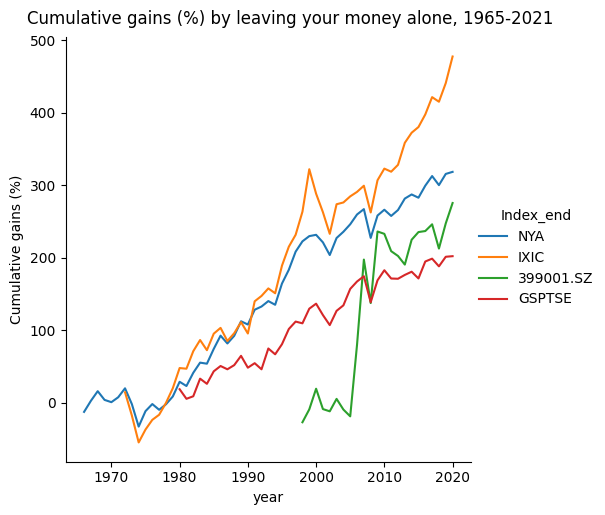

In [35]:
#cumulative % gain per year, keep your money where it is
g = sns.relplot(year.loc[year.Index_end.str.contains('NYA|IXIC|SZ|GSP')], x='Year_end', y='cumsum_year',
                hue='Index_end', 
                hue_order = ['NYA', 'IXIC', '399001.SZ', 'GSPTSE'],
                kind='line')
plt.suptitle('Cumulative gains (%) by leaving your money alone, 1965-2021', y=1.02)
plt.xlabel('year')
plt.ylabel('Cumulative gains (%)')

Text(0.5, 28.999999999999986, 'Year')

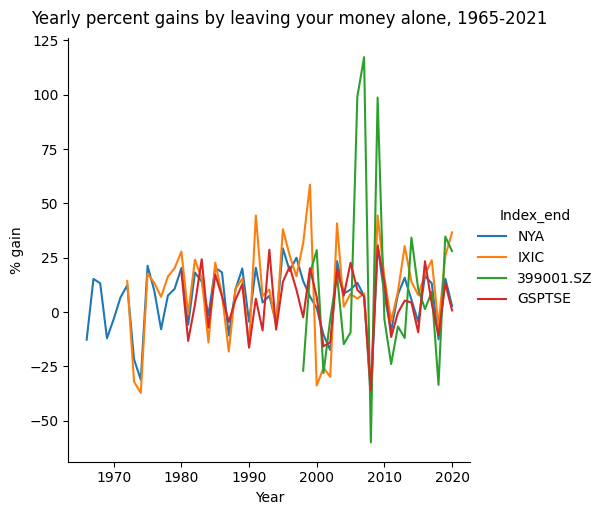

In [36]:
# % gain vs year if you leave your money alone

g = sns.relplot(year.loc[year.Index_end.str.contains('NYA|IXIC|SZ|GSP')], x='Year_end', y='year_pgain',
                hue='Index_end', 
                hue_order = ['NYA', 'IXIC', '399001.SZ', 'GSPTSE'],
                kind='line')
plt.suptitle('Yearly percent gains by leaving your money alone, 1965-2021', y=1.02)
plt.ylabel('% gain')
plt.xlabel('Year')


#### Cumulative and % gains per year when buying/selling every month

(0.0, 50.0)

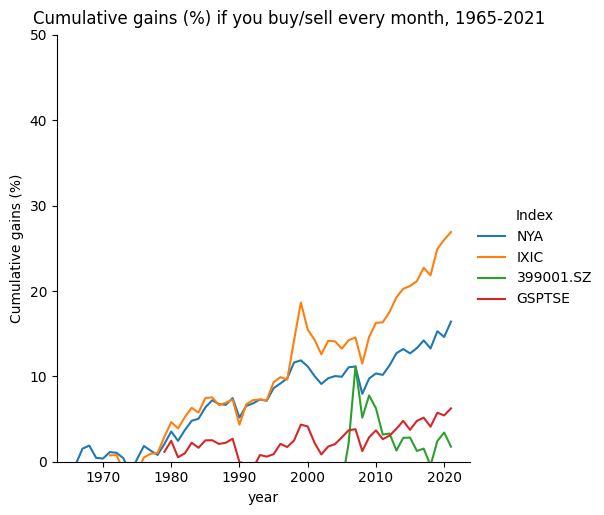

In [37]:
#Cumulative percent gain every year if you buy sell every month

g = sns.relplot(buysell_12month.loc[buysell_12month.Index.str.contains('NYA|IXIC|SZ|GSP')], x='Year_end_mean', y='cumsum_month',
                hue='Index', 
                hue_order = ['NYA', 'IXIC', '399001.SZ', 'GSPTSE'],
                kind='line')
plt.suptitle('Cumulative gains (%) if you buy/sell every month, 1965-2021', y=1.02)
plt.xlabel('year')
plt.ylabel('Cumulative gains (%)')
plt.ylim(0,50)

Text(0.5, 28.999999999999986, 'Year')

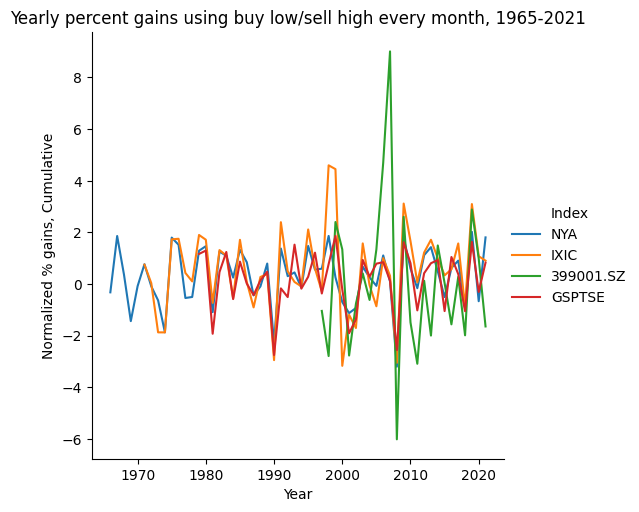

In [38]:
#pgain per year using buy/sell strategy

g = sns.relplot(buysell_12month.loc[buysell_12month.Index.str.contains('NYA|IXIC|SZ|GSP')],
                x='Year_end_mean', y='month_pgain_mean',
                kind='line',
                hue='Index',
                hue_order = ['NYA', 'IXIC', '399001.SZ', 'GSPTSE'],
               )
# plt.arrow(2000, 150, 15, -30, width=0.75)
# ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
#         verticalalignment='top', bbox=props)
plt.title('Yearly percent gains using buy low/sell high every month, 1965-2021')
plt.ylabel('Normalized % gains, Cumulative')
plt.xlabel('Year')

#### Strategy 1
##### Cumulative and %gain per year if you buy/sell every month at 10th percentile first week, 90th percentile 4th week

(0.0, 500.0)

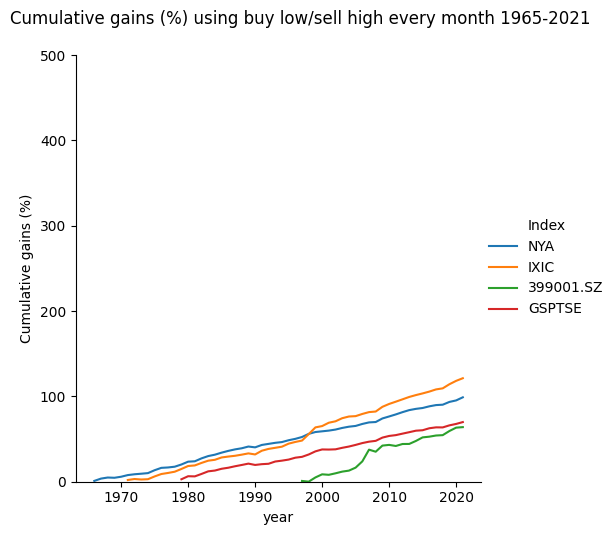

In [39]:
#cumulative % gain per year, buy/sell every month 

g = sns.relplot(buysell_12month.loc[buysell_12month.Index.str.contains('NYA|IXIC|SZ|GSP')], x='Year_end_mean', y='cumsum_strat',
                hue='Index', 
                hue_order = ['NYA', 'IXIC', '399001.SZ', 'GSPTSE'],
                kind='line')
plt.suptitle('Cumulative gains (%) using buy low/sell high every month 1965-2021', y=1.06)
plt.xlabel('year')
plt.ylabel('Cumulative gains (%)')
plt.ylim(0,500)

Text(0.5, 28.999999999999986, 'Year')

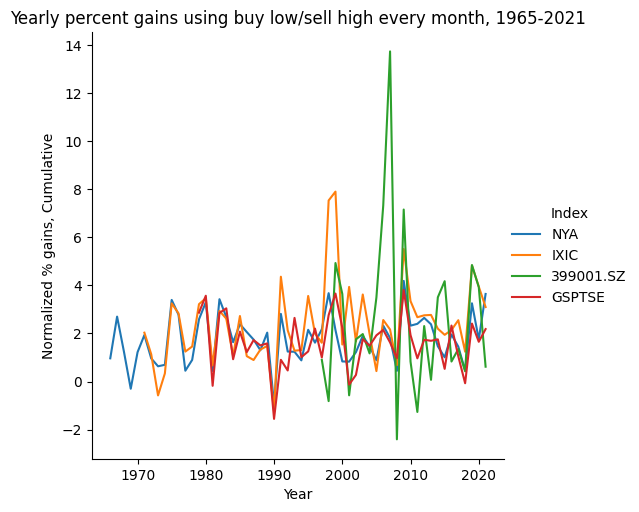

In [40]:
#pgain per year using buy/sell strategy by percntile 10/90

g = sns.relplot(buysell_12month.loc[buysell_12month.Index.str.contains('NYA|IXIC|SZ|GSP')],
                x='Year_end_mean', y='buylowsellhigh_pgain_mean',
                kind='line',
                hue='Index',
                hue_order = ['NYA', 'IXIC', '399001.SZ', 'GSPTSE'],
               )
# plt.arrow(2000, 150, 15, -30, width=0.75)
# ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
#         verticalalignment='top', bbox=props)
plt.title('Yearly percent gains using buy low/sell high every month, 1965-2021')
plt.ylabel('Normalized % gains, Cumulative')
plt.xlabel('Year')

#### Strategy 2: Golden Cross

Text(0.5, 1.0, 'Golden cross example')

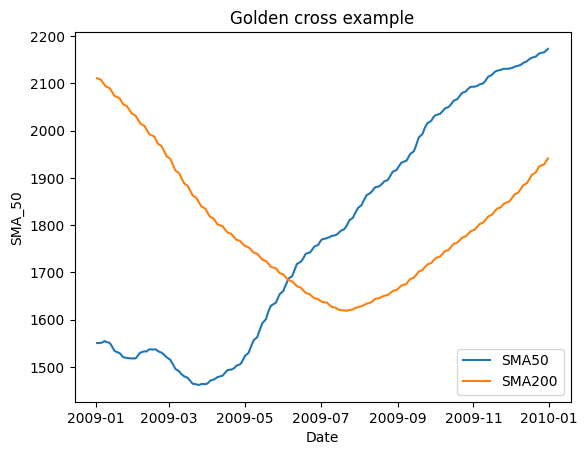

In [41]:
#golden cross example
g = sns.lineplot(df_data.loc[(df_data.Index == 'IXIC') & (df_data.Year == 2009)], x='Date', y='SMA_50', label='SMA50')
sns.lineplot(df_data.loc[(df_data.Index == 'IXIC') & (df_data.Year == 2009)], x='Date', y='SMA_200', label='SMA200')
plt.title('Golden cross example')

C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


(154, 185)


C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


(158, 185)


Text(46.73384722222221, 0.5, 'Cumulative gains (%)')

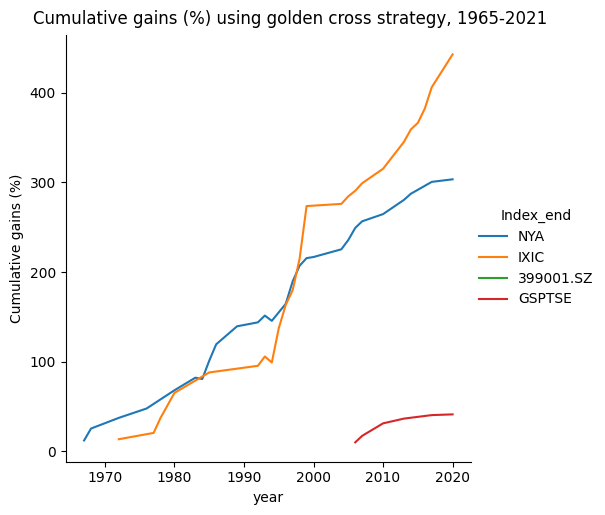

In [42]:
#Golden cross strategy, cumulative gains 
buysell_smarter1 = gains(df_data[df_data['SMA_50'] > df_data['SMA_200']], year=True)
buysell_smarter1['cumsum_year'] = buysell_smarter1.groupby('Index_end')['year_pgain'].transform('cumsum')

g = sns.relplot(buysell_smarter1.loc[buysell_smarter1.Index_end.str.contains('NYA|IXIC|SZ|GSP')], x='Year_end', y='cumsum_year',
                hue='Index_end', 
                hue_order = ['NYA', 'IXIC', '399001.SZ', 'GSPTSE'],
                kind='line')
plt.suptitle('Cumulative gains (%) using golden cross strategy, 1965-2021', y=1.02)
plt.xlabel('year')
plt.ylabel('Cumulative gains (%)')

(-60.0, 125.0)

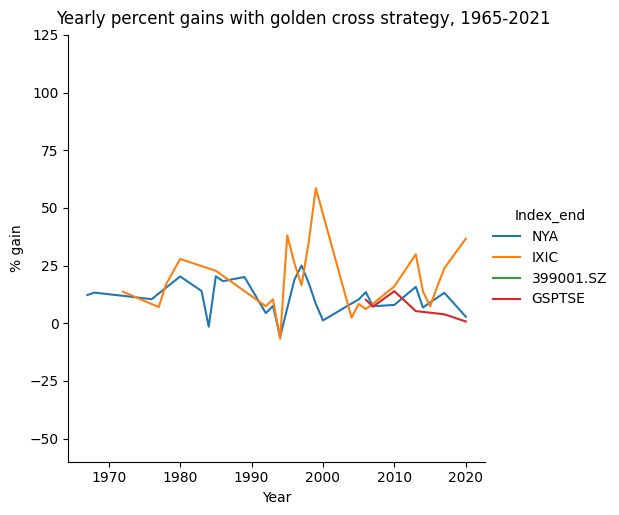

In [43]:
# % gain vs year using golden cross strategy

g = sns.relplot(buysell_smarter1.loc[buysell_smarter1.Index_end.str.contains('NYA|IXIC|SZ|GSP')], x='Year_end', y='year_pgain',
                hue='Index_end', 
                hue_order = ['NYA', 'IXIC', '399001.SZ', 'GSPTSE'],
                kind='line')
plt.suptitle('Yearly percent gains with golden cross strategy, 1965-2021', y=1.02)
plt.ylabel('% gain')
plt.xlabel('Year')
plt.ylim(-60,125)


#### Strategy 3: Momentum

Text(0.5, 1.0, 'Momentum example')

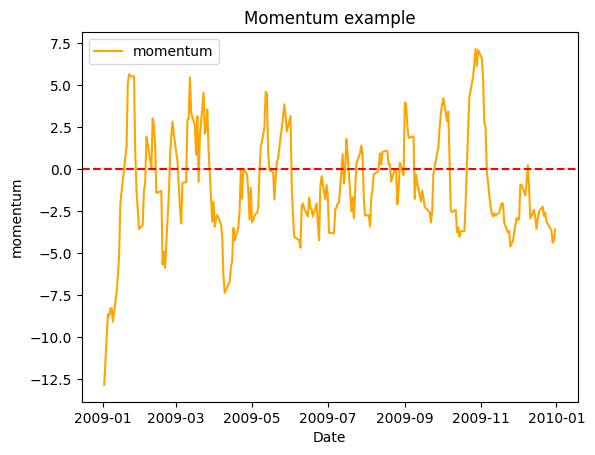

In [44]:
#momentum example
g = sns.lineplot(df_data.loc[(df_data.Index == 'IXIC') & (df_data.Year == 2009)], x='Date', y='momentum', label='momentum', color='orange')
g.axhline(y=0, color='red', ls='--')
plt.title('Momentum example')

C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


(201, 185)


C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4655: RuntimeWarning: invalid value encountered in multiply
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4655: RuntimeWarning: invalid value encountered in multiply
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,


(286, 185)


Text(46.73384722222221, 0.5, 'Cumulative gains (%)')

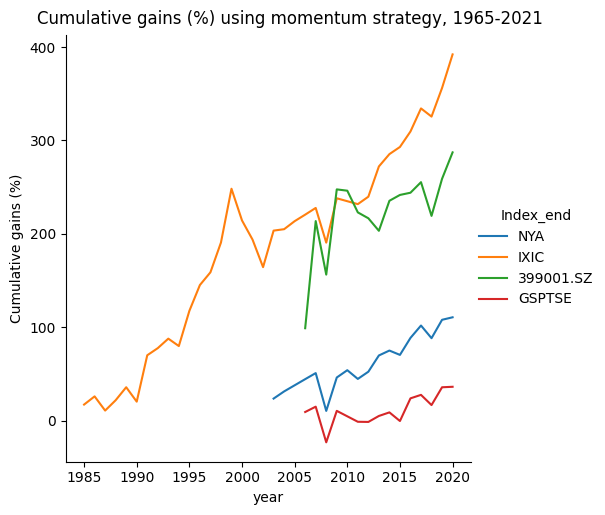

In [45]:
#momentum strategy, cumulative gains 
buysell_smarter2 = gains(df_data[df_data['momentum'] > 0], year=True)

buysell_smarter2['cumsum_year'] = buysell_smarter2.groupby('Index_end')['year_pgain'].transform('cumsum')

g = sns.relplot(buysell_smarter2.loc[buysell_smarter2.Index_end.str.contains('NYA|IXIC|SZ|GSP')], x='Year_end', y='cumsum_year',
                hue='Index_end', 
                hue_order = ['NYA', 'IXIC', '399001.SZ', 'GSPTSE'],
                kind='line')
plt.suptitle('Cumulative gains (%) using momentum strategy, 1965-2021', y=1.02)
plt.xlabel('year')
plt.ylabel('Cumulative gains (%)')


Text(0.5, 28.999999999999986, 'Year')

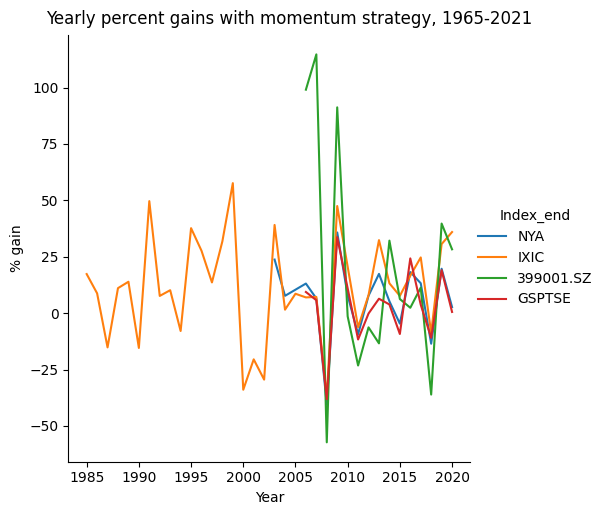

In [31]:
# % gain vs year using momentum strategy

g = sns.relplot(buysell_smarter2.loc[buysell_smarter2.Index_end.str.contains('NYA|IXIC|SZ|GSP')], x='Year_end', y='year_pgain',
                hue='Index_end', 
                hue_order = ['NYA', 'IXIC', '399001.SZ', 'GSPTSE'],
                kind='line')
plt.suptitle('Yearly percent gains with momentum strategy, 1965-2021', y=1.02)
plt.ylabel('% gain')
plt.xlabel('Year')


# Combine Dataframes with events

In [68]:
stocks_and_events_df = year.merge(events_by_year, how='left', left_on = 'Year_end', right_on = 'Year')

Text(-2, -18, 'Why are years with a lot of positive events\n showing negative yearly percent returns? ')

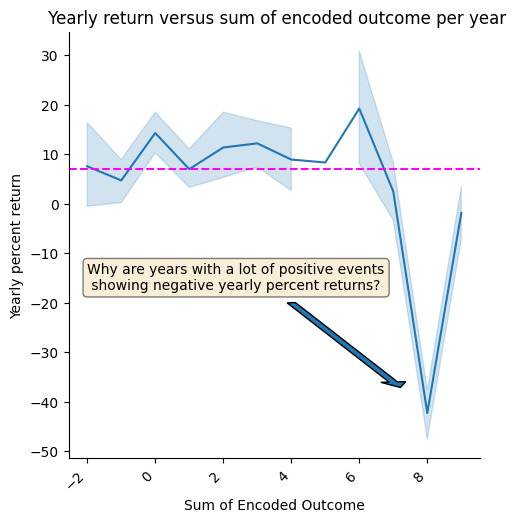

In [69]:

sns.relplot(stocks_and_events_df,
             x='eOutcome_sum',
             y='year_pgain',
             # size = 'Outcome_count',
             sizes=(10, 100),
             kind='line'
             # hue = 'eOutcome_median',
             # palette=['red','orangered','gold','yellowgreen','green']
           )
plt.xticks(rotation=45, ha='right')
plt.axhline(y=7, color='magenta', ls='--')
plt.xlabel('Sum of Encoded Outcome')
plt.ylabel('Yearly percent return')
plt.title(' Yearly return versus sum of encoded outcome per year')
plt.arrow(4,-20,3,-16, width=0.25)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(-2, -18, 'Why are years with a lot of positive events\n showing negative yearly percent returns? ', fontsize=10,
        verticalalignment='bottom', bbox=props)

### Years with a lot of positives happen to be the bubble year (economy crashes, covid, etc)
- Does this mean we don't buy when there are a lot of positive things happening with the world?
- Is there a way to put a magnitude filter on these encoded outcomes? 

In [38]:
stocks_and_events_df.loc[stocks_and_events_df.eOutcome_sum > 7].Year.unique()

array([2008, 2010, 2018, 1975])

#### Inspect and clean data for nan

In [48]:
null_summary = stocks_and_events_df.isnull().agg(['sum','mean']).T
null_summary.columns = ['null_count','null_percent']
null_summary = null_summary[null_summary['null_count'] > 0]
null_summary

,null_count,null_percent
SMA_50_min_end,83.0,0.191686
SMA_50_max_end,83.0,0.191686
SMA_50_mean_end,83.0,0.191686
SMA_50_median_end,83.0,0.191686
SMA_50_std_end,84.0,0.193995
...,...,...
momentum_mean_start,191.0,0.441109
momentum_median_start,191.0,0.441109
momentum_std_start,191.0,0.441109
momentum_percentile_10_start,191.0,0.441109


In [49]:
for col in null_summary.index:
    print(col, null_summary.loc[col].to_dict())

SMA_50_min_end {'null_count': 83.0, 'null_percent': 0.19168591224018475}
SMA_50_max_end {'null_count': 83.0, 'null_percent': 0.19168591224018475}
SMA_50_mean_end {'null_count': 83.0, 'null_percent': 0.19168591224018475}
SMA_50_median_end {'null_count': 83.0, 'null_percent': 0.19168591224018475}
SMA_50_std_end {'null_count': 84.0, 'null_percent': 0.19399538106235567}
SMA_50_percentile_10_end {'null_count': 83.0, 'null_percent': 0.19168591224018475}
SMA_50_percentile_90_end {'null_count': 83.0, 'null_percent': 0.19168591224018475}
Dist_from_SMA50_min_end {'null_count': 83.0, 'null_percent': 0.19168591224018475}
Dist_from_SMA50_max_end {'null_count': 83.0, 'null_percent': 0.19168591224018475}
Dist_from_SMA50_mean_end {'null_count': 83.0, 'null_percent': 0.19168591224018475}
Dist_from_SMA50_median_end {'null_count': 83.0, 'null_percent': 0.19168591224018475}
Dist_from_SMA50_std_end {'null_count': 84.0, 'null_percent': 0.19399538106235567}
Dist_from_SMA50_percentile_10_end {'null_count': 83

In [509]:
df_clean = stocks_and_events_df[['Daily_Return_mean_end', 'Range_mean_end', 'Volume_Change_mean_end', 'category_sum',
                                 'eOutcome_sum', 'RSI_mean_start', 'SMA_50_std_start', 'year_pgain', 'eOutcome_count','cumsum_year']]

df_clean.isnull().sum()

Daily_Return_mean_end       0
Range_mean_end              0
Volume_Change_mean_end    158
category_sum                0
eOutcome_sum                0
RSI_mean_start              0
SMA_50_std_start          193
year_pgain                  0
eOutcome_count              0
cumsum_year                 0
dtype: int64

#### Generate correlation tables for data exploration

In [241]:
num_df = stocks_and_events_df.select_dtypes(include=['float64', 'int64'])

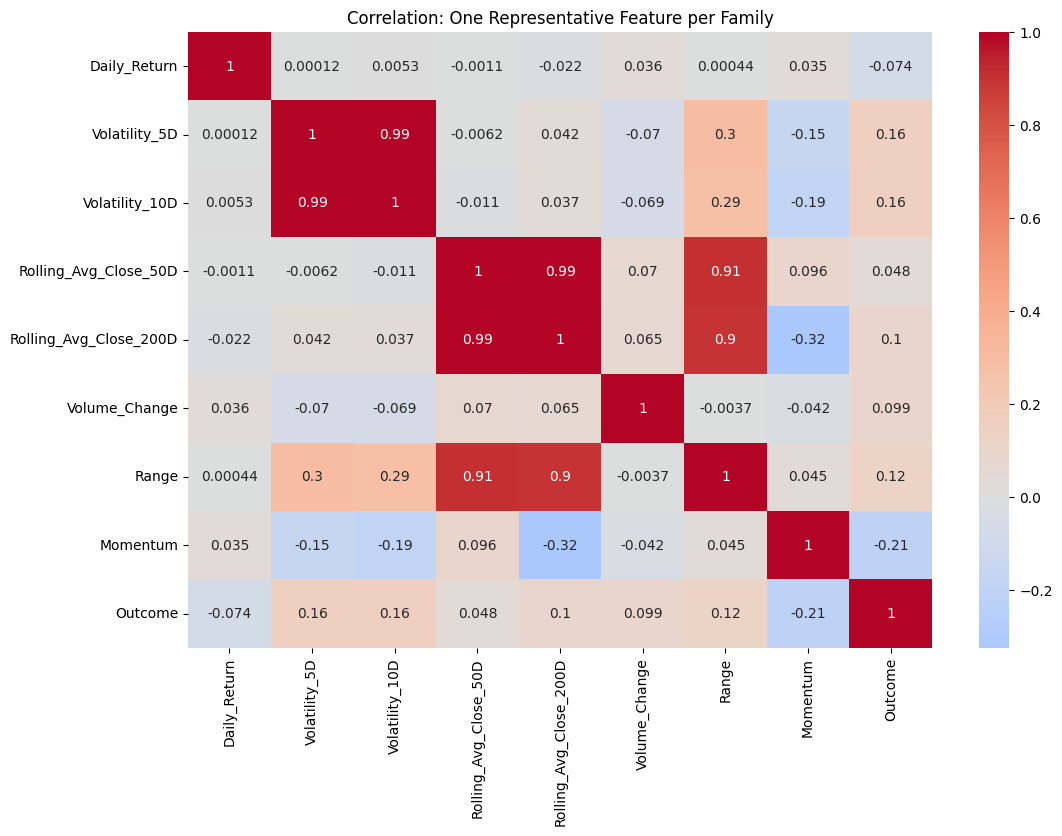

In [242]:
# --- A. ONE FEATURE PER FAMILY (HAND-PICKED REPRESENTATIVES) ---

agg_df = pd.DataFrame(index=num_df.index)

# Short-term return / target-adjacent
agg_df['Daily_Return'] = num_df['Daily_Return_mean_end']

# Volatility
agg_df['Volatility_5D']  = num_df['Volatility_5D_mean_end']
agg_df['Volatility_10D'] = num_df['Volatility_10D_mean_end']

# Trend indicators (moving averages)
agg_df['Rolling_Avg_Close_50D']  = num_df['SMA_50_mean_end']
agg_df['Rolling_Avg_Close_200D'] = num_df['SMA_200_mean_end']

# Volume change
agg_df['Volume_Change'] = num_df['Volume_Change_mean_end']

# Range (daily high-low spread)
agg_df['Range'] = num_df['Range_mean_end']

# Momentum
agg_df['Momentum'] = num_df['momentum_mean_end']

# Optional: include your target
agg_df['Outcome'] = num_df['eOutcome_sum']


# --- Visualize ---
plt.figure(figsize=(12, 8))
sns.heatmap(
    agg_df.corr(),
    annot=True,
    cmap='coolwarm',
    center=0
)
plt.title("Correlation: One Representative Feature per Family")
plt.show()


We organized ~400 engineered features into ~10 major families, such as volatility, range, momentum, and moving averages. This helps avoid redundancy and simplifies interpretation.

C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:2888: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:2888: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


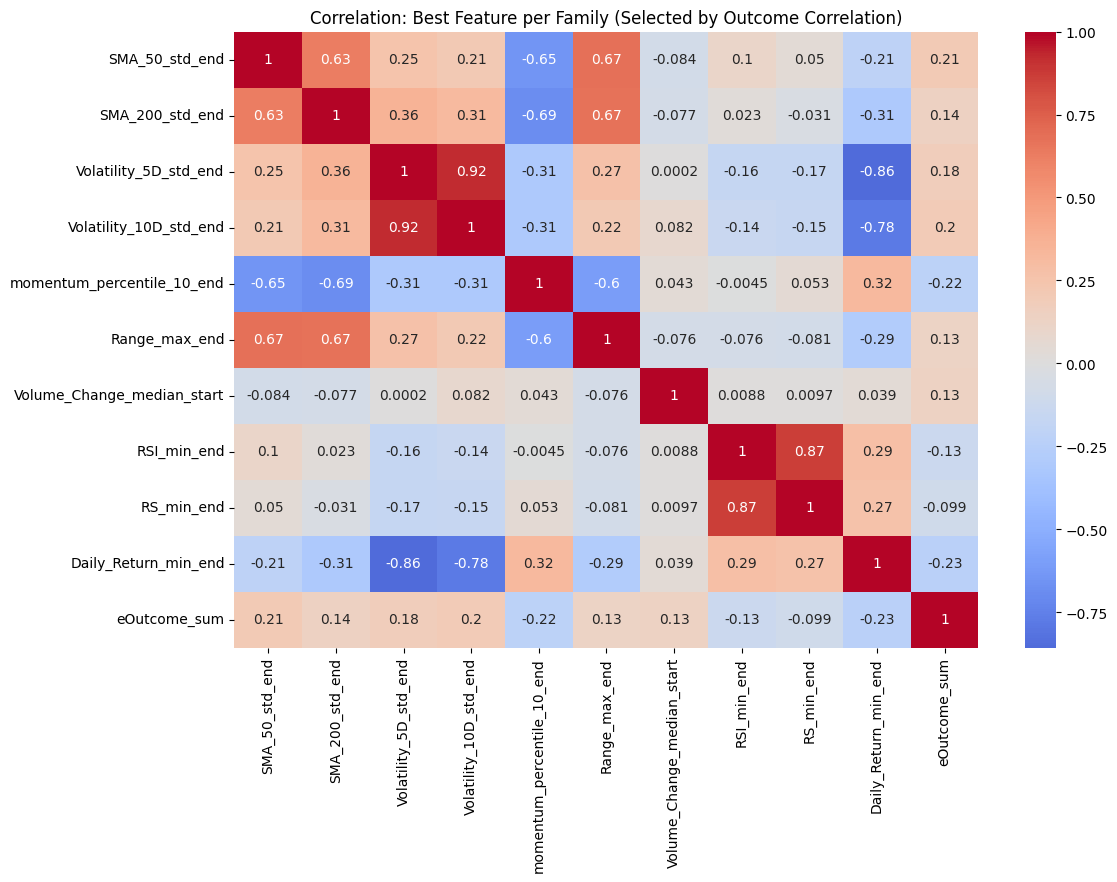

In [243]:
# --- C. BEST FEATURE PER FAMILY (CHOSEN BY CORRELATION WITH TARGET) ---

target = 'eOutcome_sum'

# Define feature families based on name prefixes
families = {
    'SMA_50':        num_df.filter(regex='^SMA_50_'),
    'SMA_200':       num_df.filter(regex='^SMA_200_'),
    'Vol_5D':        num_df.filter(regex='^Volatility_5D_'),
    'Vol_10D':       num_df.filter(regex='^Volatility_10D_'),
    'Momentum':      num_df.filter(regex='^momentum_'),
    'Range':         num_df.filter(regex='^Range_'),
    'Volume_Change': num_df.filter(regex='^Volume_Change_'),
    'RSI':           num_df.filter(regex='^RSI_'),
    'RS':            num_df.filter(regex='^RS_'),
    'Daily_Return':  num_df.filter(regex='^Daily_Return_')
}

best_features = {}

for name, group in families.items():
    if group.shape[1] == 0:
        continue  # skip empty groups
    corrs = group.corrwith(num_df[target]).abs()
    best_col = corrs.idxmax()
    best_features[name] = best_col

# Create dataframe with only best-per-family columns
best_df = num_df[list(best_features.values()) + [target]]

# --- Visualize ---
plt.figure(figsize=(12, 8))
sns.heatmap(
    best_df.corr(),
    annot=True,
    cmap='coolwarm',
    center=0
)
plt.title("Correlation: Best Feature per Family (Selected by Outcome Correlation)")
plt.show()


While each feature family contains many variants, we automatically selected the single metric per family that had the strongest correlation with the outcome. This lets us compare how predictive each family actually is.

## Step 3:  Identify 1-3 research questions and perform analysis

### How does the market react to world events?

### Is it better to buy and hold, or is it better to buy low/sell high every month?
- Compare golden cross vs RSI strategy using buy/hold S&P500 as benchmark



We are picking some select features to now clean in model
- Daily_Return, Range, Volume_Change

In [510]:
df_clean = df_clean.replace([np.inf, -np.inf], np.nan)
df_clean = df_clean.fillna(0)

#### Recreate sentiment and count columns to help models perform better
- Also create a violence tracker to focus only on negative events.
- Separate negative events out into military and diasters, and bin those further. This is the best compromise I could think of for assessing magnitude
    - tests questions "is there more or less profit in violent or disaster years
- Encode yearly pgain 

In [513]:
df_clean.loc[df_clean['eOutcome_sum']==0, "Sentiment"] = 0
df_clean.loc[df_clean['eOutcome_sum']>0, "Sentiment"] = 1
df_clean.loc[df_clean['eOutcome_sum']< 0, "Sentiment"] = -1

In [514]:
df_clean.loc[df_clean['eOutcome_count'].between(0,5), "event_freq"] = 0
df_clean.loc[df_clean['eOutcome_count'].between(5,10), "event_freq"] = 1
df_clean.loc[df_clean['eOutcome_count'].between(10,50), "event_freq"] = 2

In [551]:
df_clean.loc[:, 'violence_freq'] =  df_clean.category_sum.apply(lambda x: len(re.findall('violen|mili', x)))
df_clean.loc[:, 'disaster_freq'] =  df_clean.category_sum.apply(lambda x: len(re.findall('disaster', x)))

df_clean.loc[(df_clean.violence_freq.between(0,2)), 'violence_freq'] = 0
df_clean.loc[(df_clean.violence_freq.between(2,5)), 'violence_freq'] = 1
df_clean.loc[(df_clean.violence_freq.between(5,20)), 'violence_freq'] = 2

df_clean.loc[(df_clean.disaster_freq > 0), 'disaster_freq'] = 1
df_clean.loc[(df_clean.disaster_freq <= 0), 'disaster_freq'] = 0

In [552]:
df_clean.loc[(df_clean.year_pgain < 0), 'encoded_pgain'] = -1
df_clean.loc[(df_clean.year_pgain.between(0,7)), 'encoded_pgain'] = 0
df_clean.loc[(df_clean.year_pgain > 7), 'encoded_pgain'] = 1

#### Create separate Classification Model_df and insert previously identified key features to put into model

In [564]:
df_model = df_clean.copy()
#X = df_model[list(best_features.values())]
X = df_model.drop(columns=['Sentiment','eOutcome_sum','event_freq','eOutcome_count', 'category_sum', 'violence_freq','disaster_freq', 'encoded_pgain'])
y = df_model['Sentiment']
# y = df_model['event_freq']

In [565]:
def model(model_df, model = '', dropcols = [],classcol = []):
    X = model_df.drop(columns = dropcols)
    y = model_df[classcol]
    X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
    )
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test)

    if model == 'log':
    
        log_clf = LogisticRegression(
        multi_class='multinomial',
        class_weight='balanced',   # important for -1/0/1 imbalance
        max_iter=2000
        )
        
        log_clf.fit(X_train_scaled, y_train)

        print("Logicstic Regression:\n",
        classification_report(y_test, log_clf.predict(X_test_scaled)))
        y_pred = log_clf.predict(X_test)
        cm = confusion_matrix(y_test, y_pred, labels=log_clf.classes_)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                      display_labels=log_clf.classes_)
        disp.plot()
        disp.ax_.set_title('Logistic')
        
        return X_train, X_train_scaled, X_test, X_test_scaled, y_train, y_test, log_clf
        
    if model == 'rf':
        rf_clf = RandomForestClassifier(
            n_estimators=400,
            max_depth=6,
            class_weight='balanced',
            random_state=42
        )
        
        rf_clf.fit(X_train, y_train)   # RF does NOT use scaled data
        
        print("Random Forest:\n",
        classification_report(y_test, rf_clf.predict(X_test)))
        y_pred = rf_clf.predict(X_test)
        cm = confusion_matrix(y_test, y_pred, labels=rf_clf.classes_)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                      display_labels=rf_clf.classes_)
        disp.plot()
        disp.ax_.set_title('RF')
        
        return X_train, X_train_scaled, X_test, X_test_scaled, y_train, y_test, rf_clf

In [566]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

In [567]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


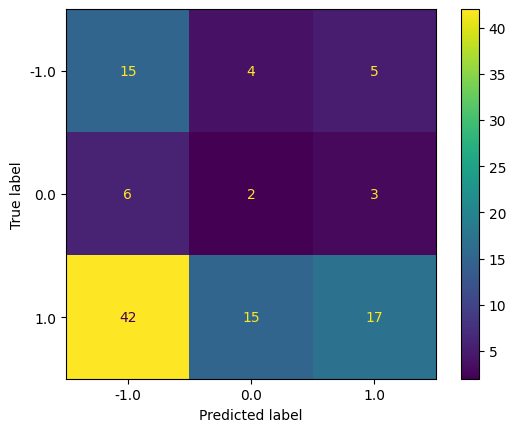

In [568]:
log_clf = LogisticRegression(
    multi_class='multinomial',
    class_weight='balanced',   # important for -1/0/1 imbalance
    max_iter=2000
)

log_clf.fit(X_train_scaled, y_train)
y_pred = log_clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred, labels=log_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=log_clf.classes_)
disp.plot()

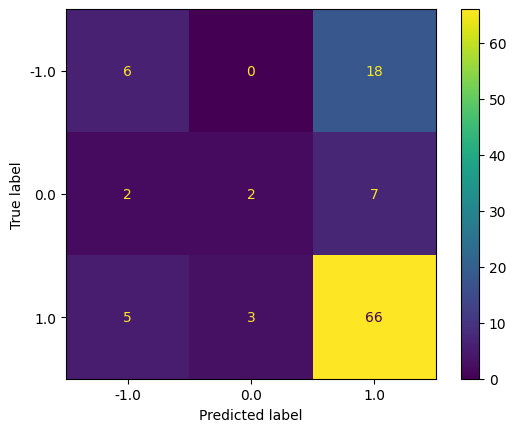

In [569]:
rf_clf = RandomForestClassifier(
    n_estimators=400,
    max_depth=6,
    class_weight='balanced',
    random_state=42
)

rf_clf.fit(X_train, y_train)   # RF does NOT use scaled data
y_pred = rf_clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred, labels=rf_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=rf_clf.classes_)
disp.plot()

In [570]:
print("Logistic Regression:\n",
      classification_report(y_test, log_clf.predict(X_test_scaled)))

print("Random Forest:\n",
      classification_report(y_test, rf_clf.predict(X_test)))


Logistic Regression:
               precision    recall  f1-score   support

        -1.0       0.37      0.71      0.49        24
         0.0       0.10      0.27      0.15        11
         1.0       0.79      0.36      0.50        74

    accuracy                           0.43       109
   macro avg       0.42      0.45      0.38       109
weighted avg       0.63      0.43      0.46       109

Random Forest:
               precision    recall  f1-score   support

        -1.0       0.46      0.25      0.32        24
         0.0       0.40      0.18      0.25        11
         1.0       0.73      0.89      0.80        74

    accuracy                           0.68       109
   macro avg       0.53      0.44      0.46       109
weighted avg       0.63      0.68      0.64       109



In [571]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score

print("LR Accuracy:", accuracy_score(y_test, log_clf.predict(X_test_scaled)))
print("LR Balanced Accuracy:", balanced_accuracy_score(y_test, log_clf.predict(X_test_scaled)))

print("RF Accuracy:", accuracy_score(y_test, rf_clf.predict(X_test)))
print("RF Balanced Accuracy:", balanced_accuracy_score(y_test, rf_clf.predict(X_test)))


LR Accuracy: 0.43119266055045874
LR Balanced Accuracy: 0.44864182364182364
RF Accuracy: 0.6788990825688074
RF Balanced Accuracy: 0.44123669123669124


In [572]:
from sklearn.metrics import roc_auc_score

# Need probability predictions
lr_probs = log_clf.predict_proba(X_test_scaled)
rf_probs = rf_clf.predict_proba(X_test)

print("LR AUC (OvR):", roc_auc_score(y_test, lr_probs, multi_class='ovr'))
print("RF AUC (OvR):", roc_auc_score(y_test, rf_probs, multi_class='ovr'))

LR AUC (OvR): 0.5930788203897448
RF AUC (OvR): 0.6854834890549176


## Step 4:  Present your findings

In this step, you can begin to report your findings.  What did you learn from the data and how do your findings help answer your research question?  Use _matplotlib_ visualizations to present these findings.


__Remember:__ Rarely will a single data analysis conclusively answer a research question.  Here, you need to identify possible limitations.  For example, are your results limited to a certain area, city, or country?  Are you making assumptions about the data which may, or may not, be valid (e.g., that students in one term are equally qualified as students in another)?  Document these limitations in a few paragraphs.


C:\Users\jlu2\AppData\Local\Temp\ipykernel_24804\1522325276.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=imp_df, x="importance", y="feature", palette="viridis")


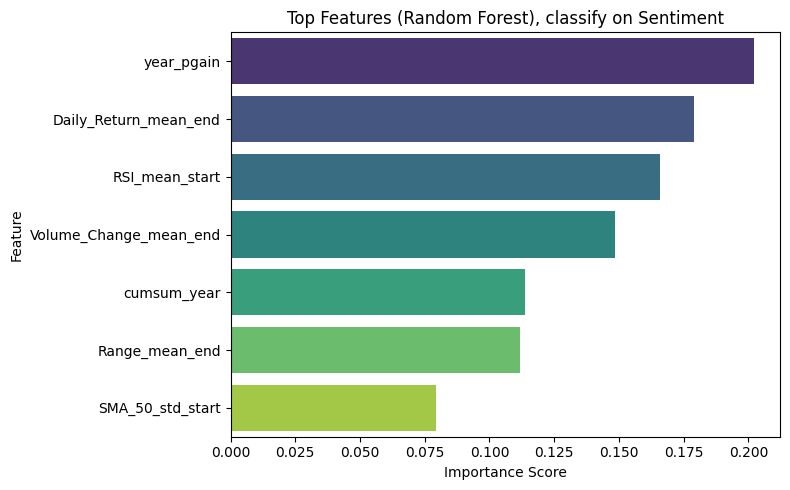

In [573]:
importances = rf_clf.feature_importances_
feat_names = X_train.columns

imp_df = pd.DataFrame({
    "feature": feat_names,
    "importance": importances
}).sort_values("importance", ascending=False).head(10)

plt.figure(figsize=(8,5))
sns.barplot(data=imp_df, x="importance", y="feature", palette="viridis")
plt.title("Top Features (Random Forest), classify on Sentiment")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


The strongest feature towards predicting sentiment is the yearly percent gain. If the sentiment is positive (good things happen in the world), we tend to make more money!  

The second strongest clue is whether the Daily return. If the average return was positive, sentiment tended to be positive; if it drifted down, sentiment skewed negative.

The third strongest clue is the RSI at the start of the year. RSI is an indicator of if a stock is overbought (>70) or oversold (<30). In essence, the more people buy, the more positive the sentiment is. 

One note to make is that category_count is agnostic to whether or not the event was positive or negative. From prior data exploration, we do know that most of the events are positive, so this would skew the sentiment prediction a bit. Due to this, we decided to omit category_count as it would overfit the model. 

The next biggest clue is how trading volume changed. Big spikes or drops in volume often happen when investors react strongly to news, and that behavior lines up with shifts in sentiment.

Together, that means the model is relying mostly on price trend and investor activity to decide whether the market’s reaction was positive, negative, or neutral.

From the confusion matrices, there seems to be an overabundance of "positive" events, as the RF forest classifier is pretty at picking those up. The Logistic model is not as great and assigns a "negative" sentiment score to "positive" sentiment years. 

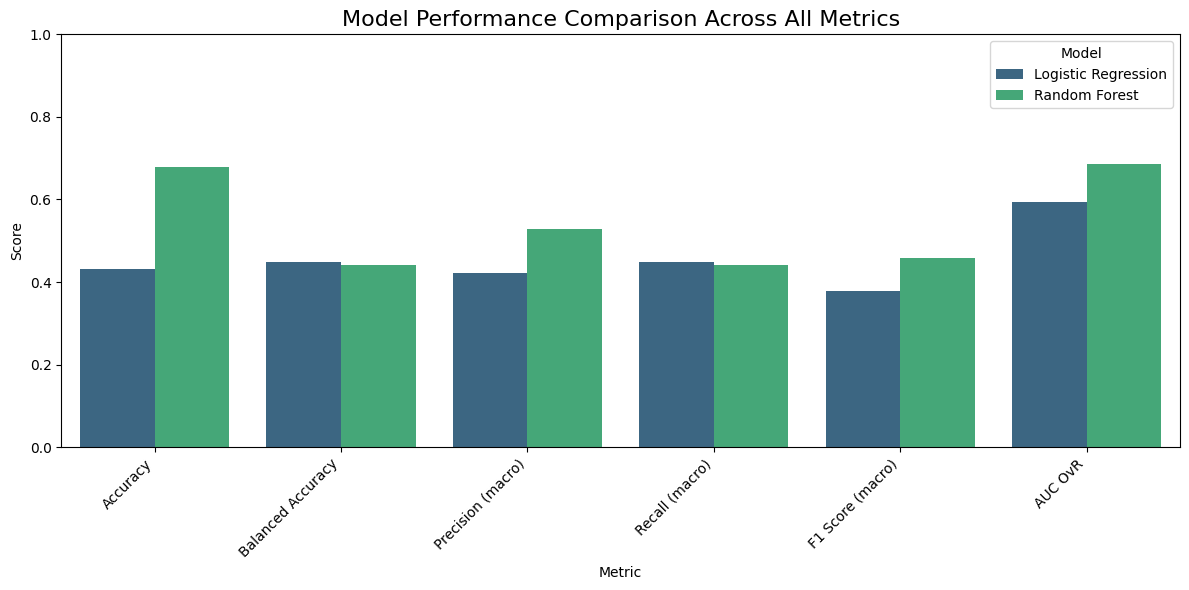

,Model,Accuracy,Balanced Accuracy,Precision (macro),Recall (macro),F1 Score (macro),AUC OvR
0,Logistic Regression,0.431193,0.448642,0.422377,0.448642,0.378571,0.593079
1,Random Forest,0.678899,0.441237,0.528938,0.441237,0.458108,0.685483


In [574]:
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, precision_score,
    recall_score, f1_score, roc_auc_score
)

# Evaluate each model
def evaluate_model(model, X_eval, y_eval, model_name):
    preds = model.predict(X_eval)
    probs = model.predict_proba(X_eval)

    return {
        "Model": model_name,
        "Accuracy": accuracy_score(y_eval, preds),
        "Balanced Accuracy": balanced_accuracy_score(y_eval, preds),
        "Precision (macro)": precision_score(y_eval, preds, average="macro", zero_division=0),
        "Recall (macro)": recall_score(y_eval, preds, average="macro", zero_division=0),
        "F1 Score (macro)": f1_score(y_eval, preds, average="macro", zero_division=0),
        "AUC OvR": roc_auc_score(y_eval, probs, multi_class="ovr")
    }

# Build performance rows
results = []
results.append(evaluate_model(log_clf, X_test_scaled, y_test, "Logistic Regression"))
results.append(evaluate_model(rf_clf, X_test, y_test, "Random Forest"))

perf_df = pd.DataFrame(results)

# Visual comparisin


# Melt the dataframe for seaborn
perf_melt = perf_df.melt(id_vars="Model", var_name="Metric", value_name="Score")

plt.figure(figsize=(12, 6))
sns.barplot(data=perf_melt, x="Metric", y="Score", hue="Model", palette="viridis")

plt.title("Model Performance Comparison Across All Metrics", fontsize=16)
plt.xticks(rotation=45, ha="right")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

perf_df


### Rerun model, but classify based on the number of events happening 

C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

Logicstic Regression:
               precision    recall  f1-score   support

         0.0       0.24      0.91      0.38        11
         1.0       0.59      0.35      0.44        49
         2.0       0.62      0.49      0.55        49

    accuracy                           0.47       109
   macro avg       0.48      0.58      0.46       109
weighted avg       0.56      0.47      0.48       109

Random Forest:
               precision    recall  f1-score   support

         0.0       0.40      0.18      0.25        11
         1.0       0.55      0.59      0.57        49
         2.0       0.65      0.67      0.66        49

    accuracy                           0.59       109
   macro avg       0.53      0.48      0.49       109
weighted avg       0.58      0.59      0.58       109



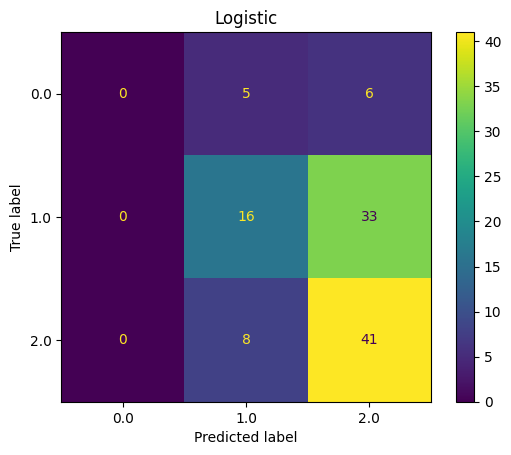

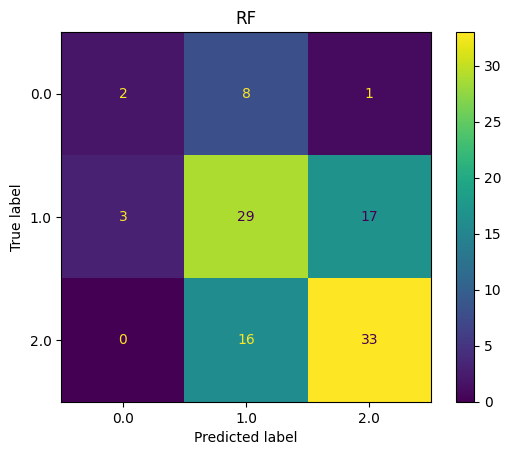

In [575]:
X_train, X_train_scaled, X_test, X_test_scaled, y_train, y_test, log_clf = model(df_model, model = 'log', dropcols = ['Sentiment','eOutcome_sum','event_freq','eOutcome_count', 'category_sum', 'violence_freq','disaster_freq', 'encoded_pgain'], classcol = ['event_freq'])
X_train, X_train_scaled, X_test, _ , y_train, y_test, rf_clf = model(df_model, model = 'rf', dropcols = ['Sentiment','eOutcome_sum','event_freq','eOutcome_count', 'category_sum', 'violence_freq','disaster_freq', 'encoded_pgain'], classcol = ['event_freq'])

In [576]:
# Need probability predictions
lr_probs = log_clf.predict_proba(X_test_scaled)
rf_probs = rf_clf.predict_proba(X_test)

print("LR AUC (OvR):", roc_auc_score(y_test, lr_probs, multi_class='ovr'))
print("RF AUC (OvR):", roc_auc_score(y_test, rf_probs, multi_class='ovr'))


LR AUC (OvR): 0.6814368171511029
RF AUC (OvR): 0.7839105339105338


C:\Users\jlu2\AppData\Local\Temp\ipykernel_24804\1909131669.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=imp_df, x="importance", y="feature", palette="viridis")


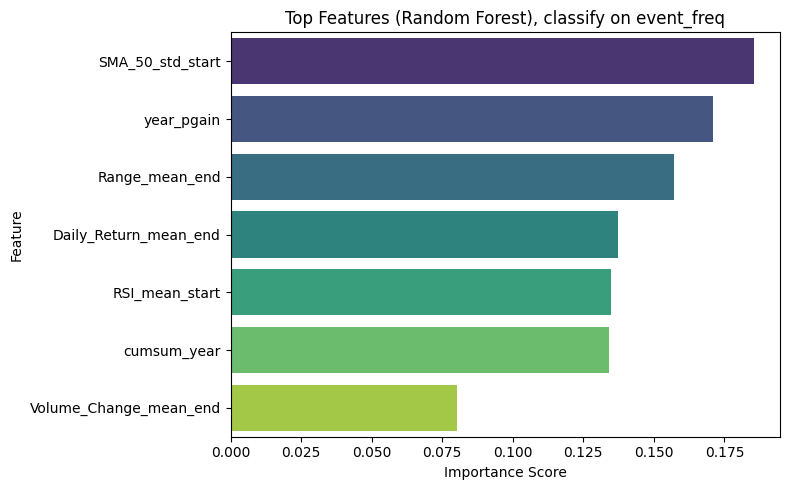

In [577]:
importances = rf_clf.feature_importances_
feat_names = X_train.columns

imp_df = pd.DataFrame({
    "feature": feat_names,
    "importance": importances
}).sort_values("importance", ascending=False).head(10)

plt.figure(figsize=(8,5))
sns.barplot(data=imp_df, x="importance", y="feature", palette="viridis")
plt.title("Top Features (Random Forest), classify on event_freq")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


The strongest feature towards predicting the number of events is the SMA_50 standard deviation at the start of the year. If there are a lot of events happening, we will see a higher standard deviation in prices (aka volatility)

The second and third strongest features are yearly percent gain and price range. If there are alot of events happening, our total price range (open - close) and yearly percent gains will be higher. 

Of interesting note, the RSI, year percent gains, and cumulative gains for the year are not as important as the volatility of the market when it  comes to predicting if there are alot of events happening in the world. 

Overall, we see that more volatile trading years (higher standard deviations and range) are aligned with more events occuring in the world. 

### Rerun model, but classify based on the number of violent/military events

C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

Logicstic Regression:
               precision    recall  f1-score   support

           0       0.38      0.34      0.36        47
           1       0.38      0.23      0.29        47
           2       0.18      0.47      0.26        15

    accuracy                           0.31       109
   macro avg       0.31      0.35      0.30       109
weighted avg       0.35      0.31      0.32       109

Random Forest:
               precision    recall  f1-score   support

           0       0.53      0.53      0.53        47
           1       0.55      0.57      0.56        47
           2       0.31      0.27      0.29        15

    accuracy                           0.51       109
   macro avg       0.46      0.46      0.46       109
weighted avg       0.51      0.51      0.51       109



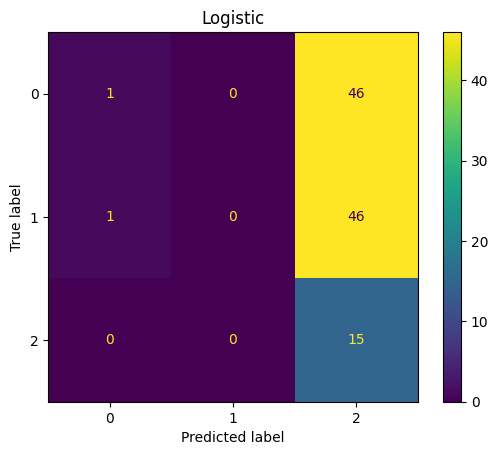

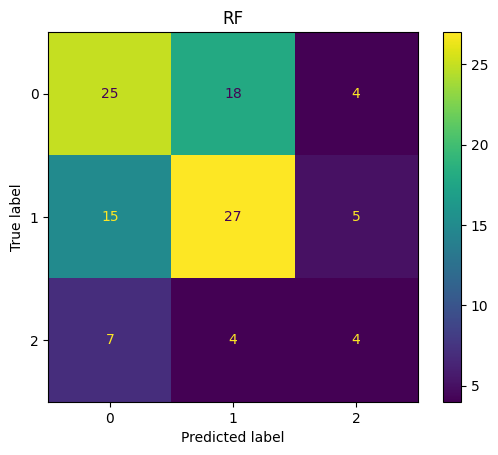

In [578]:
X_train, X_train_scaled, X_test, X_test_scaled, y_train, y_test, log_clf = model(df_model, model = 'log', dropcols = ['Sentiment','eOutcome_sum','event_freq','eOutcome_count', 'category_sum', 'violence_freq','disaster_freq', 'encoded_pgain'], classcol = ['violence_freq'])
X_train, X_train_scaled, X_test, _ , y_train, y_test, rf_clf = model(df_model, model = 'rf', dropcols = ['Sentiment','eOutcome_sum','event_freq','eOutcome_count', 'category_sum', 'violence_freq','disaster_freq', 'encoded_pgain'], classcol = ['violence_freq'])

In [549]:
# Need probability predictions
lr_probs = log_clf.predict_proba(X_test_scaled)
rf_probs = rf_clf.predict_proba(X_test)

print("LR AUC (OvR):", roc_auc_score(y_test, lr_probs, multi_class='ovr'))
print("RF AUC (OvR):", roc_auc_score(y_test, rf_probs, multi_class='ovr'))


LR AUC (OvR): 0.5392129947380462
RF AUC (OvR): 0.7076794021200336


C:\Users\jlu2\AppData\Local\Temp\ipykernel_24804\4017167457.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=imp_df, x="importance", y="feature", palette="viridis")


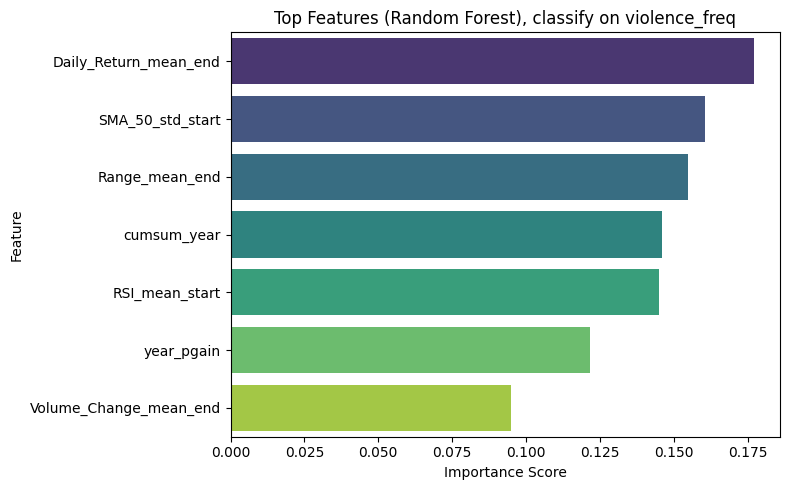

In [579]:
importances = rf_clf.feature_importances_
feat_names = X_train.columns

imp_df = pd.DataFrame({
    "feature": feat_names,
    "importance": importances
}).sort_values("importance", ascending=False).head(10)

plt.figure(figsize=(8,5))
sns.barplot(data=imp_df, x="importance", y="feature", palette="viridis")
plt.title("Top Features (Random Forest), classify on violence_freq")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

When trying to model military/violent events by stock market data, we see that yearly percent gain and cumulative yearly gains are not at the top of the list. The Daily return (top indicator from our sentiment-market model) and SMA_50_std (top indicator from event frequency-market model) are the top two features here, which suggest higher volatility and higher daily returns are most likely associated with more violent years. 

Logistic model has a terrible confusion matrix and an accuracy score of 0.32, so that one is not very useful.
RF model has a decent confusion matrix and an accuracy score of 0.51, which is an okay starting point. 


### Rerun model, but classify based on the number of disasters

C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1262: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:1365: DataCo

Logicstic Regression:
               precision    recall  f1-score   support

           0       0.85      0.66      0.74        83
           1       0.36      0.62      0.46        26

    accuracy                           0.65       109
   macro avg       0.60      0.64      0.60       109
weighted avg       0.73      0.65      0.67       109

Random Forest:
               precision    recall  f1-score   support

           0       0.80      0.80      0.80        83
           1       0.35      0.35      0.35        26

    accuracy                           0.69       109
   macro avg       0.57      0.57      0.57       109
weighted avg       0.69      0.69      0.69       109



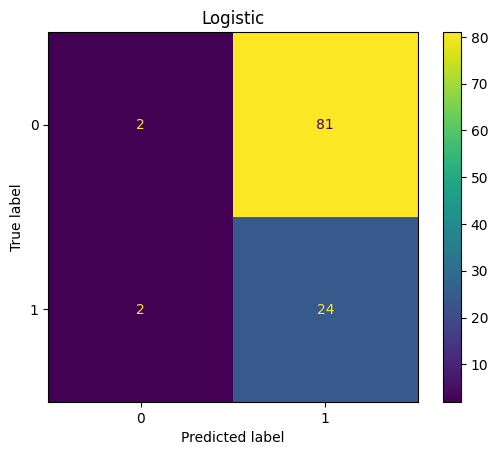

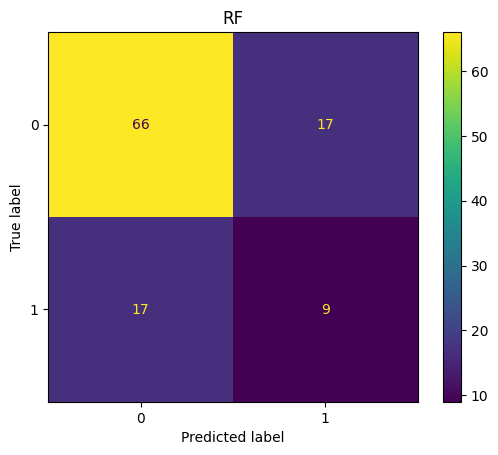

In [580]:
X_train, X_train_scaled, X_test, X_test_scaled, y_train, y_test, log_clf = model(df_model, model = 'log', dropcols = ['Sentiment','eOutcome_sum','event_freq','eOutcome_count', 'category_sum', 'violence_freq','disaster_freq', 'encoded_pgain'], classcol = ['disaster_freq'])
X_train, X_train_scaled, X_test, _ , y_train, y_test, rf_clf = model(df_model, model = 'rf', dropcols = ['Sentiment','eOutcome_sum','event_freq','eOutcome_count', 'category_sum', 'violence_freq','disaster_freq', 'encoded_pgain'], classcol = ['disaster_freq'])

In [556]:
# Need probability predictions
lr_probs = log_clf.predict_proba(X_test_scaled)
rf_probs = rf_clf.predict_proba(X_test)

print("LR AUC (OvR):", roc_auc_score(y_test, lr_probs[:,1], multi_class='ovr'))
print("RF AUC (OvR):", roc_auc_score(y_test, rf_probs[:,1], multi_class='ovr'))


LR AUC (OvR): 0.6946246524559778
RF AUC (OvR): 0.7099165894346617


C:\Users\jlu2\AppData\Local\Temp\ipykernel_24804\3934210889.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=imp_df, x="importance", y="feature", palette="viridis")


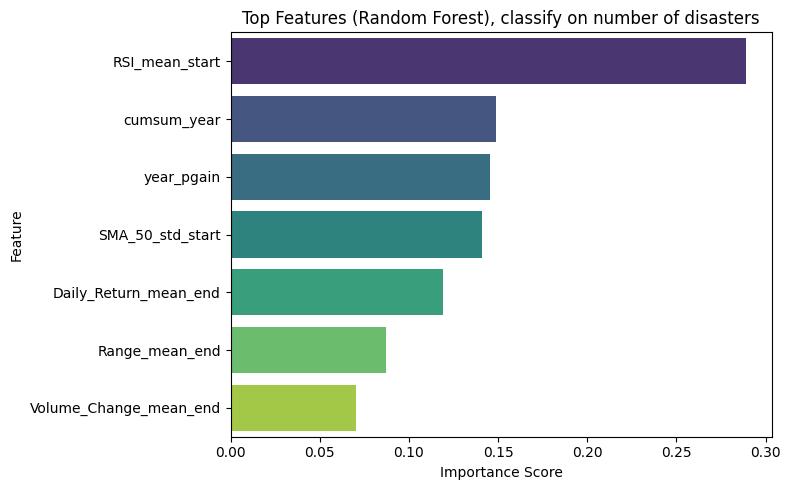

In [581]:
importances = rf_clf.feature_importances_
feat_names = X.columns

imp_df = pd.DataFrame({
    "feature": feat_names,
    "importance": importances
}).sort_values("importance", ascending=False).head(10)

plt.figure(figsize=(8,5))
sns.barplot(data=imp_df, x="importance", y="feature", palette="viridis")
plt.title("Top Features (Random Forest), classify on number of disasters")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

When trying to model disaster events (binary yes/no, did a year have a disaster) by stock market data, we see that RSI is a dominating factor. Moreover, we do see that the cumulative sum, yearly percent gain, and SMA_50 standard deivation are roughly equilvalent secondary factors, which indicates that volatility and high gains are also associated with years that have disasters. 

Logistic model has a terrible confusion matrix and an accuracy score of 0.67, so that one is not very useful.
RF model has a decent confusion matrix and an accuracy score of 0.69, which is a good starting point. 

Having a high RSI at the start of the year seems to be an indicator of bubble years, which is a decent warning sign to start hedging bets and being more conservative. 

### Model yearly percent gain as function of encoded events 

C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\jlu2\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

Logicstic Regression:
               precision    recall  f1-score   support

        -1.0       0.41      0.41      0.41        37
         0.0       0.07      0.13      0.10        15
         1.0       0.62      0.49      0.55        57

    accuracy                           0.41       109
   macro avg       0.37      0.34      0.35       109
weighted avg       0.47      0.41      0.44       109

Random Forest:
               precision    recall  f1-score   support

        -1.0       0.72      0.62      0.67        37
         0.0       0.15      0.13      0.14        15
         1.0       0.67      0.75      0.71        57

    accuracy                           0.62       109
   macro avg       0.51      0.50      0.51       109
weighted avg       0.62      0.62      0.62       109



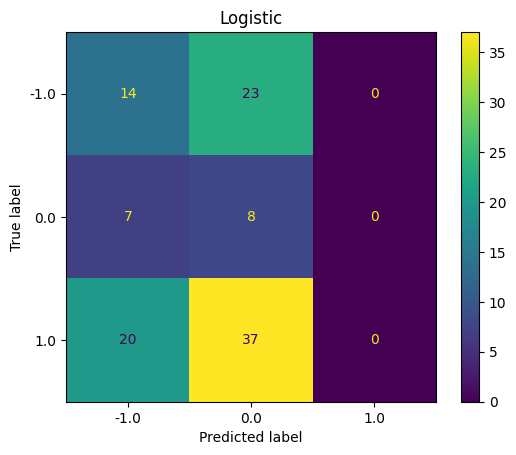

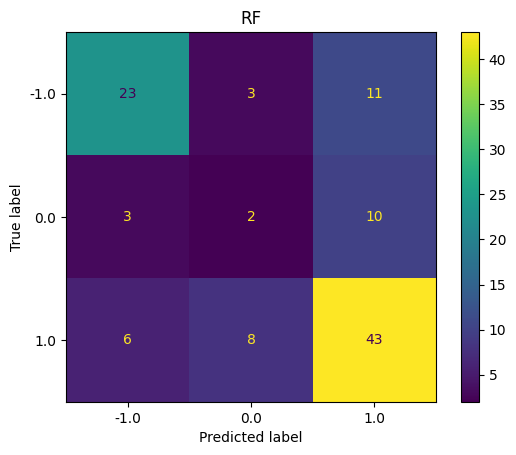

In [582]:
columns = ['Daily_Return_mean_end', 'Range_mean_end', 'Volume_Change_mean_end',
       'category_sum', 'eOutcome_sum', 'RSI_mean_start', 'SMA_50_std_start',
       'year_pgain', 'cumsum_year', 'encoded_pgain']
X_train, X_train_scaled, X_test, X_test_scaled, y_train, y_test, log_clf = model(df_model, model = 'log', dropcols = columns, classcol = ['encoded_pgain'])
X_train, X_train_scaled, X_test, _ , y_train, y_test, rf_clf = model(df_model, model = 'rf', dropcols = columns, classcol = ['encoded_pgain'])

C:\Users\jlu2\AppData\Local\Temp\ipykernel_24804\2338072768.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=imp_df, x="importance", y="feature", palette="viridis")


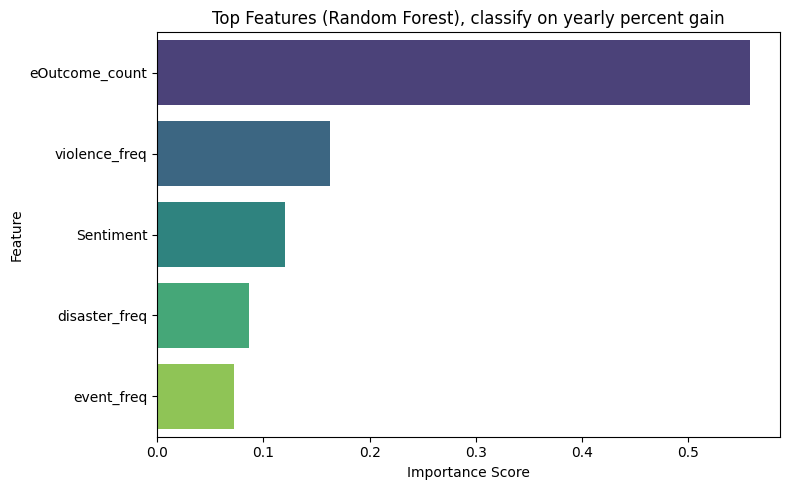

In [583]:
importances = rf_clf.feature_importances_
feat_names = X_train.columns

imp_df = pd.DataFrame({
    "feature": feat_names,
    "importance": importances
}).sort_values("importance", ascending=False).head(10)

plt.figure(figsize=(8,5))
sns.barplot(data=imp_df, x="importance", y="feature", palette="viridis")
plt.title("Top Features (Random Forest), classify on yearly percent gain")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

- Generally, yearly percent gains are closely tied to the number of total events a year (eOutcome_count is just the total number of positive and
      negative events in that year)
- Positive events were not separtely encoded since it was difficult to ascertain how "positive" events were, but fairly easy to assess that disasters and military events are generally negative events.
    - The positive events are skewing the magnitude-agnostic "Sentiment" category, which suggests that we have a strong representation of positive events anyways
    - Violence frequency is slightly stronger than overall sentiment, which indicates that even though are overall more "positive" events happening in the world, the number of violent events has a marginally stronger association with market movements.
    - The encoded disaster_freq and event_freq did not have much association with the encoded market
    - For future work, perhaps I could train an LLM on this dataset to sort positive/negative events, or even use AI to create a magnitude grader.
    
      